In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import sys
from pathlib import Path
parent_dir = Path("..").resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from utils.file_parsers import vars2dict, parse_kmfile, parse_ohrbets

DATAFOLDER = Path("../data")

✅ Configuration loaded successfully from C:\Github\lickcalc\config.yaml


In [2]:
filepath = DATAFOLDER / "ohrbets-offsets.csv"

df = parse_ohrbets(filepath)

In [3]:
import json
import io

jsonified_df = df["32"]
onset = pd.read_json(io.StringIO(jsonified_df), orient='split')

jsonified_df = df["82"]
offset = pd.read_json(io.StringIO(jsonified_df), orient='split')

In [5]:
len(offset)

68

(0.0, 3.0)

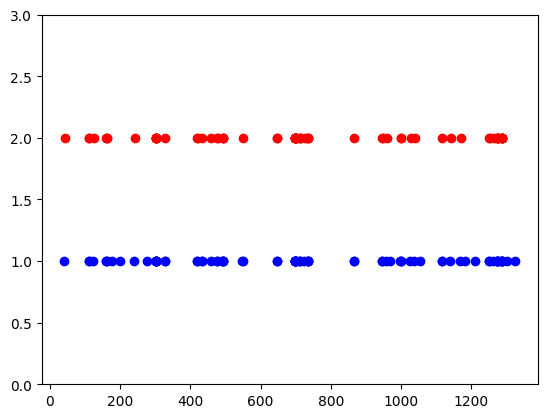

In [9]:
import matplotlib.pyplot as plt

plt.scatter(onset, [1]*len(onset), color='blue', label='onset')
plt.scatter(offset, [2]*len(offset), color='red', label='offset')

plt.ylim(0, 3)

In [46]:
for i in range(30, 40):
    print("lick", i, offset.iloc[i] - onset.iloc[i])

lick 30 licks    205.155
Name: 30, dtype: float64
lick 31 licks    151.78
Name: 31, dtype: float64
lick 32 licks    149.968
Name: 32, dtype: float64
lick 33 licks    53.888
Name: 33, dtype: float64
lick 34 licks    52.944
Name: 34, dtype: float64
lick 35 licks    2.599
Name: 35, dtype: float64
lick 36 licks    2.803
Name: 36, dtype: float64
lick 37 licks    13.948
Name: 37, dtype: float64
lick 38 licks    14.58
Name: 38, dtype: float64
lick 39 licks    15.056
Name: 39, dtype: float64


## Identify Missing or Misaligned Offsets

In [10]:
# Method 1: Check for offsets that come after the next onset
problems = []
for i in range(len(onset) - 1):
    if i < len(offset):
        # Offset should be between current onset and next onset
        if not (onset.iloc[i] < offset.iloc[i] < onset.iloc[i+1]):
            problems.append({
                'index': i,
                'onset': onset.iloc[i],
                'offset': offset.iloc[i] if i < len(offset) else None,
                'next_onset': onset.iloc[i+1],
                'issue': 'offset outside valid range'
            })
    else:
        problems.append({
            'index': i,
            'onset': onset.iloc[i],
            'offset': None,
            'next_onset': onset.iloc[i+1],
            'issue': 'missing offset'
        })

# Check if lengths match
if len(onset) != len(offset):
    print(f"⚠️ Length mismatch: {len(onset)} onsets vs {len(offset)} offsets")
    print(f"   Difference: {abs(len(onset) - len(offset))} {'missing offsets' if len(onset) > len(offset) else 'extra offsets'}")

print(f"\nFound {len(problems)} problematic lick(s):")
for p in problems[:10]:  # Show first 10
    print(f"  Lick {p['index']}: onset={p['onset']:.3f}, offset={p['offset']}, next_onset={p['next_onset']:.3f} - {p['issue']}")

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [11]:
# Method 2: Vectorized approach (more efficient for large arrays)
import pandas as pd

# Create a DataFrame for easier analysis
df = pd.DataFrame({
    'onset': onset,
    'offset': offset[:len(onset)] if len(offset) >= len(onset) else list(offset) + [None]*(len(onset)-len(offset))
})

# Add next onset for comparison
df['next_onset'] = df['onset'].shift(-1)

# Identify problems
df['duration'] = df['offset'] - df['onset']
df['valid'] = (df['offset'] > df['onset']) & (df['offset'] < df['next_onset'])

# Mark specific issues
df['issue'] = 'OK'
df.loc[df['offset'].isna(), 'issue'] = 'missing offset'
df.loc[df['offset'] <= df['onset'], 'issue'] = 'offset before/at onset'
df.loc[(df['offset'] >= df['next_onset']) & df['next_onset'].notna(), 'issue'] = 'offset after next onset'

# Show problematic licks
problematic = df[df['issue'] != 'OK']
print(f"\n{len(problematic)} problematic licks found:\n")
print(problematic[['onset', 'offset', 'next_onset', 'duration', 'issue']].head(20))

ValueError: Data must be 1-dimensional, got ndarray of shape (85, 1) instead

In [ ]:
# Visualize the problematic regions
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

# Plot all licks
ax.scatter(onset, [1]*len(onset), color='blue', alpha=0.5, label='onset', s=20)
ax.scatter(offset, [1.5]*len(offset), color='green', alpha=0.5, label='offset', s=20)

# Highlight problematic licks
if len(problematic) > 0:
    problem_indices = problematic.index
    ax.scatter(onset.iloc[problem_indices], [1]*len(problem_indices), 
               color='red', s=100, marker='x', label='problematic onset', linewidths=2)
    
    # Draw lines connecting onset-offset pairs for problematic licks
    for idx in problem_indices[:20]:  # Limit to first 20 for clarity
        if not pd.isna(df.loc[idx, 'offset']):
            ax.plot([df.loc[idx, 'onset'], df.loc[idx, 'offset']], 
                   [1, 1.5], 'r--', alpha=0.5, linewidth=1)

ax.set_ylim(0.5, 2)
ax.set_xlabel('Time (s)')
ax.set_yticks([1, 1.5])
ax.set_yticklabels(['Onset', 'Offset'])
ax.legend()
ax.set_title(f'Lick Events ({len(problematic)} problematic out of {len(onset)} total)')
plt.tight_layout()
plt.show()

## LS file parser

In [ ]:
from pyparsing import line


filepath = DATAFOLDER / "ls_test1.txt"


line_no = next((i for i, line in enumerate(open(filepath, encoding="utf-8"), 1)))

                 if line.lstrip().startswith("PRESENTATION")), None)

                


In [5]:
import csv
filepath = DATAFOLDER / "ls_test1.txt"

def find_presentation_line(filepath):
    with open(filepath, newline='') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if row[0] == "PRESENTATION":
                return i
            
line_no = find_presentation_line(filepath)
print(line_no)

            

9


In [ ]:


def find_presentation_line(filepath, str2search="PRESENTATION"):
    with open(filepath, newline='') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if row[0] == str2search:
                return i

def get_ilis_from_file(filepath, datastart=None):

    return (
        pd
        .read_csv(filepath, skiprows=datastart+2, header=None)
        .astype(np.int32)
        .iloc[0,:]
        .T
        .reset_index(drop=True)
        .values
    )

def parse_lsfile(filepath):

    datastart = find_presentation_line(filepath)

    df = get_ilis_from_file(filepath, datastart=datastart)
    solution = pd.read_csv(filepath, skiprows=datastart, nrows=1)["SOLUTION"].values[0].strip()
    latency = pd.read_csv(filepath, skiprows=datastart, nrows=1)[" Latency"].values[0]

    all_ilis = np.array([latency] + df.tolist())
    licks = np.cumsum(all_ilis)
    licks_in_seconds = licks / 1000

    data_array = {}
    data_array[solution] = licks_in_seconds

    return vars2dict(data_array)

filepath = DATAFOLDER / "ls_test1.txt"
filepath = DATAFOLDER / "ls_test2.txt"

data = parse_lsfile(filepath)



10


In [12]:
pd.read_csv(filepath, skiprows=9, nrows=1).columns

Index(['PRESENTATION', 'TUBE', 'CONCENTRATION', 'SOLUTION', '  IPI  ',
       '  LTL  ', ' MAX LICKS', ' LICKS', ' Latency', ' Open Error',
       ' Close Error'],
      dtype='object')

In [13]:
df = get_ilis_from_file(filepath)
solution = pd.read_csv(filepath, skiprows=9, nrows=1)["SOLUTION"].values[0].strip()
latency = pd.read_csv(filepath, skiprows=9, nrows=1)[" Latency"].values[0]

all_ilis = np.array([latency] + df.tolist())
licks = np.cumsum(all_ilis)
licks_in_seconds = licks / 1000

In [14]:
np.sum(all_ilis < 0)

np.int64(0)

Text(0.5, 0, 'Time (s)')

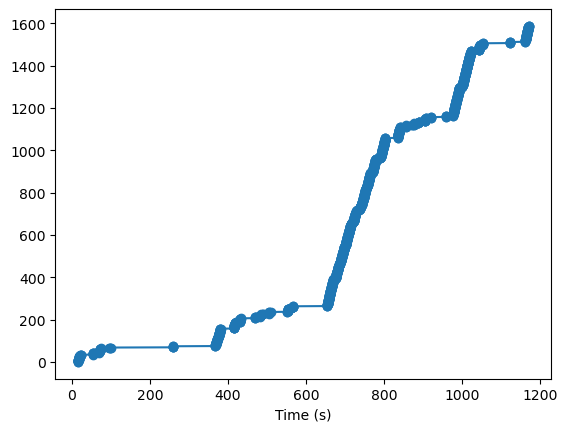

In [15]:
import matplotlib.pyplot as plt
plt.plot(licks_in_seconds, np.arange(len(licks_in_seconds)), marker='o')
plt.xlabel('Time (s)')

## OHRBETS file parser

In [25]:
import csv

filename = DATAFOLDER / "2023_10_16_jem04.csv"

def parse_ohrbets(filename):
    codes, ts = [], []

    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) > 0:
                row = row[0].split(" ")
                codes.append(int(row[0]))
                ts.append(int(row[1]) / 1000)

    df = pd.DataFrame({"code": codes, "ts": ts})

    code_dict = {}
    for code in df.code.unique():
        code_dict[code] = df.query("code == @code").ts.values

    data_array = vars2dict(code_dict)

    return data_array

parse_ohrbets(filename)

{np.int64(11): '{"columns":["licks"],"index":[0,1],"data":[[0.0],[600.001]]}',
 np.int64(130): '{"columns":["licks"],"index":[0],"data":[[0.0]]}',
 np.int64(127): '{"columns":["licks"],"index":[0,1],"data":[[0.0],[0.001]]}',
 np.int64(13): '{"columns":["licks"],"index":[0],"data":[[0.0]]}',
 np.int64(998): '{"columns":["licks"],"index":[0],"data":[[0.206]]}',
 np.int64(1): '{"columns":["licks"],"index":[0],"data":[[0.0]]}',
 np.int64(100): '{"columns":["licks"],"index":[0],"data":[[600.0]]}',
 np.int64(116): '{"columns":["licks"],"index":[0],"data":[[0.034]]}',
 np.int64(31): '{"columns":["licks"],"index":[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,

In [24]:
data_array

{np.int64(11): '{"columns":["licks"],"index":[0,1],"data":[[0.0],[600.001]]}',
 np.int64(130): '{"columns":["licks"],"index":[0],"data":[[0.0]]}',
 np.int64(127): '{"columns":["licks"],"index":[0,1],"data":[[0.0],[0.001]]}',
 np.int64(13): '{"columns":["licks"],"index":[0],"data":[[0.0]]}',
 np.int64(998): '{"columns":["licks"],"index":[0],"data":[[0.206]]}',
 np.int64(1): '{"columns":["licks"],"index":[0],"data":[[0.0]]}',
 np.int64(100): '{"columns":["licks"],"index":[0],"data":[[600.0]]}',
 np.int64(116): '{"columns":["licks"],"index":[0],"data":[[0.034]]}',
 np.int64(31): '{"columns":["licks"],"index":[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,

## Med legacy file parser

In [3]:
filename = DATAFOLDER / "2025-04-28_10h38m_Subject 2285_M_Con.txt"

In [29]:
import re

def parse_med_arraystyle(filename):
    """Parser for Med-PC format arrays, i.e. not column-based."""
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    arrays = {}
    current_array = None
    
    for line in lines:
        # Check for array label (e.g., "L:" or "R:")
        if re.match(r'^[A-Z]:$', line.strip()):
            current_array = line.strip()[0]  # Get just the letter
            arrays[current_array] = []
        # Check for data lines (start with spaces and numbers)
        elif current_array and re.match(r'^\s+\d+:', line):
            # Extract all decimal numbers from the line
            numbers = re.findall(r'\d+\.\d+', line)
            arrays[current_array].extend([float(n) for n in numbers])
    
    # Remove trailing zeros
    for key in arrays:
        while arrays[key] and arrays[key][-1] == 0.0:
            arrays[key].pop()

    
    data_array = vars2dict(arrays)
    return data_array



data = parse_med_arraystyle(filename)
print(f"L (licks?): {len(data['L'])} timestamps")
print(f"R (rewards?): {len(data['R'])} timestamps")


L (licks?): 7312 timestamps
R (rewards?): 20315 timestamps


In [34]:
data

{'L': '{"columns":["licks"],"index":[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,2

In [33]:
datakm = parse_kmfile(DATAFOLDER / "M2512B_2025_09_22__16_29_07.csv")

datakm

{'Lick': '{"columns":["licks"],"index":[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,26

In [27]:
arrays["L"]

[158.44,
 158.61,
 158.79,
 159.68,
 490.46,
 492.89,
 493.25,
 496.25,
 676.92,
 677.18,
 677.46,
 677.67,
 678.02,
 681.39,
 681.6,
 681.73,
 681.95,
 682.44,
 682.58,
 682.94,
 683.06,
 683.16,
 683.48,
 683.6,
 898.93,
 899.25,
 899.65,
 902.96,
 903.22,
 906.15,
 909.39,
 909.58,
 909.99,
 910.29,
 929.87,
 930.02,
 930.35,
 930.45,
 930.65,
 931.07,
 933.28,
 933.38,
 933.47,
 933.59,
 933.66,
 933.79,
 934.25,
 934.37,
 934.67,
 934.79,
 937.89,
 938.0,
 938.18,
 938.3,
 938.41,
 938.72,
 940.83,
 940.94,
 941.13,
 941.24,
 941.68,
 941.79,
 941.91,
 942.01,
 942.34,
 942.74,
 945.74,
 945.81,
 946.13,
 946.24,
 946.59,
 946.68,
 946.8,
 946.91,
 947.14,
 947.24,
 947.56,
 947.67,
 950.07,
 950.2,
 950.3,
 950.41,
 950.63,
 950.75,
 950.87,
 1246.15,
 1246.23,
 1246.45,
 1246.62,
 1246.81,
 1247.13,
 1247.35,
 1247.45,
 1247.64,
 1247.87,
 1248.32,
 1253.28,
 1253.35,
 1253.44,
 1253.65,
 1253.76,
 1254.05,
 1254.18,
 1254.38,
 1254.49,
 1254.8,
 1704.2,
 1704.37,
 1704.55,
 170

In [19]:
type(arrays["L"])

str

## KM file parser

In [ ]:
filename = DATAFOLDER / "M2512B_2025_09_22__16_29_07.csv"
header=9

df = pd.read_csv(filename,
                 skiprows=header,
                 header=None,
                 names=["row", "timestamp", "input", "eventcode", "event", "empty1", "empty2"]
                 )



In [ ]:
df

In [ ]:
vars = {}
for event in df.event.unique():
    tmp = df.query("event == @event").timestamp.values
    vars[event] = tmp

    print(event)

In [ ]:
vars

In [ ]:
df.head()

In [ ]:
def parse_kmfile(f, header=9):

    df = pd.read_csv(filename,
                    skiprows=header,
                    header=None,
                    names=["row", "timestamp", "input", "eventcode", "event", "empty1", "empty2"]
                    )
    
    vars = {}
for event in df.event.unique():
    tmp = df.query("event == @event").timestamp.values
    vars[event] = tmp
    
    return vars

In [18]:
from pathlib import Path
import trompy

DATAFOLDER = Path("../data")
list_of_files = [
    "med_test2.med",
    "med_test3.med"
]

results_dict = {}
for file in list_of_files:
    results_dict[file] = {}
    onset, offset = trompy.medfilereader(DATAFOLDER / file,
                                         varsToExtract=["b", "c"],
                                         remove_var_header=True
                                         )

    lickdata = trompy.lickcalc(onset, offset=offset,
                                #some variables
                                )
    results_dict[file]["total_licks"] = lickdata["total"]
    results_dict[file]["burst_number"] = lickdata["bNum"]
    results_dict[file]["licks_per_burst"] = lickdata["bMean"]

In [19]:
results_dict

{'med_test2.med': {'total_licks': 2872,
  'burst_number': 342,
  'licks_per_burst': np.float64(8.397660818713451)},
 'med_test3.med': {'total_licks': 1845,
  'burst_number': 92,
  'licks_per_burst': np.float64(20.054347826086957)}}

In [14]:
f = list_of_files[2]
trompy.medfilereader(f,
                     varsToExtract=["e", "f"],
                     remove_var_header=True)

[[], []]

In [11]:
trompy.medfilereader?

Signature:
trompy.medfilereader(
    filename,
    vars_to_extract='all',
    session_to_extract=1,
    verbose=False,
    remove_var_header=False,
    dictionary_output=False,
    **kwargs,
)
Docstring:
Reads in Med Associates file stored as single column and returns variables as lists.

Parameters
----------
filename : str
    File to be read in.
varsToExtract : str or list of str, optional
    (e.g. ['a', 'b', 'f']), default is 'all'
sessionToExtract : int, optional
    Can be specified for situations in which more than one session is included in a single file. Deafult is 1.
verbose : bool, optional
    Prints statements with file information. Default is False.
remove_var_header : bool, optional
    Removes first value in array, useful when negative numbers are used as markers to signal array start. Default is False.

Returns
-------
varsToReturn : list of lists of numbers (int or float)
    Variables extracted from medfile as lists or a list of lists ('all')
File:      c:\users\jmc